In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 93% 138M/149M [00:01<00:00, 117MB/s]
100% 149M/149M [00:01<00:00, 90.1MB/s]


In [3]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [4]:
tr_df = get_class_paths("/content/Training")

In [5]:
ts_df = get_class_paths("/content/Testing")

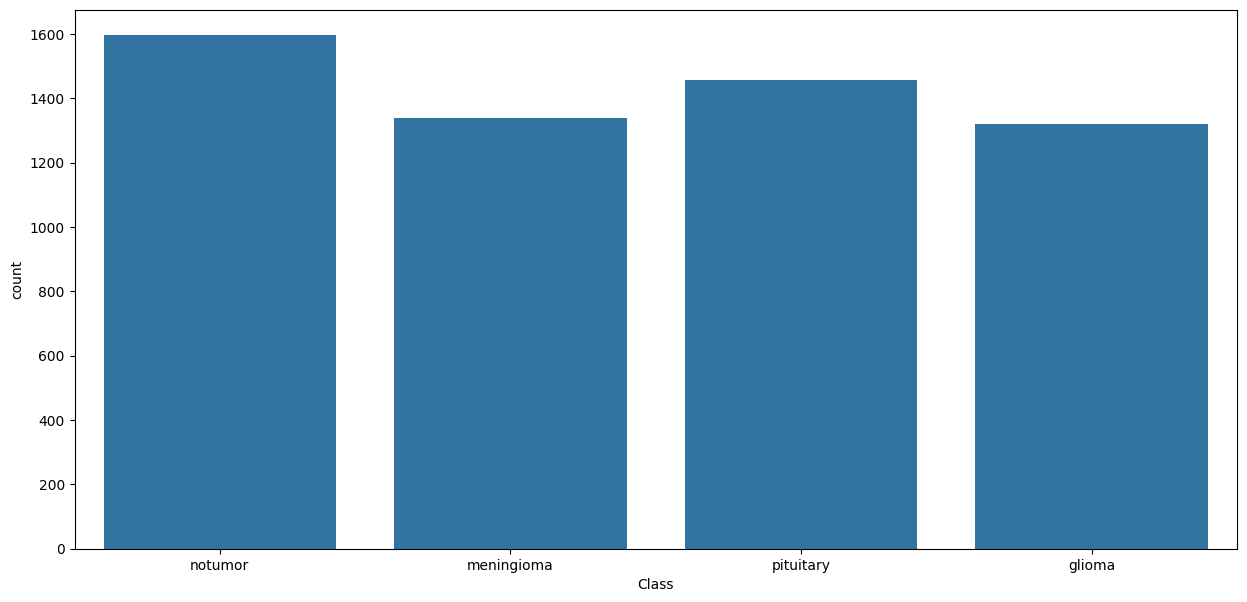

In [6]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])

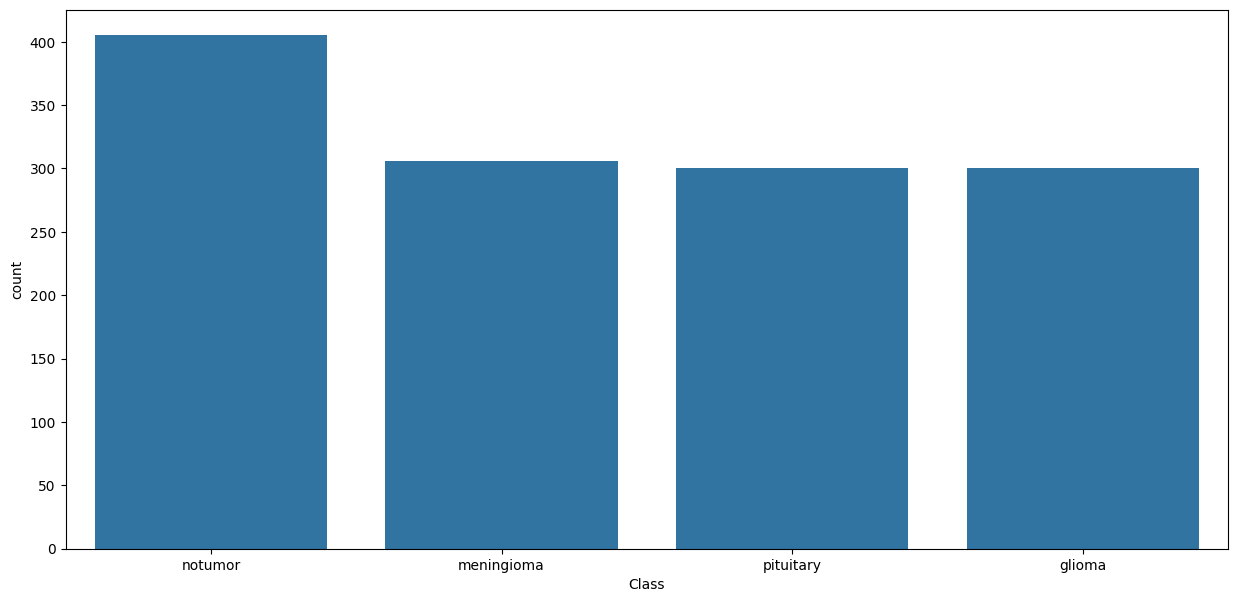

In [7]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [10]:
# Standardize Image Size and Brightness to improve consistency.
batch_size = 32

img_size = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [11]:
# Takes Traning DF and creates flow of images from DF
tr_gen = image_generator.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

# Keeping order of Testing Data consistent
ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


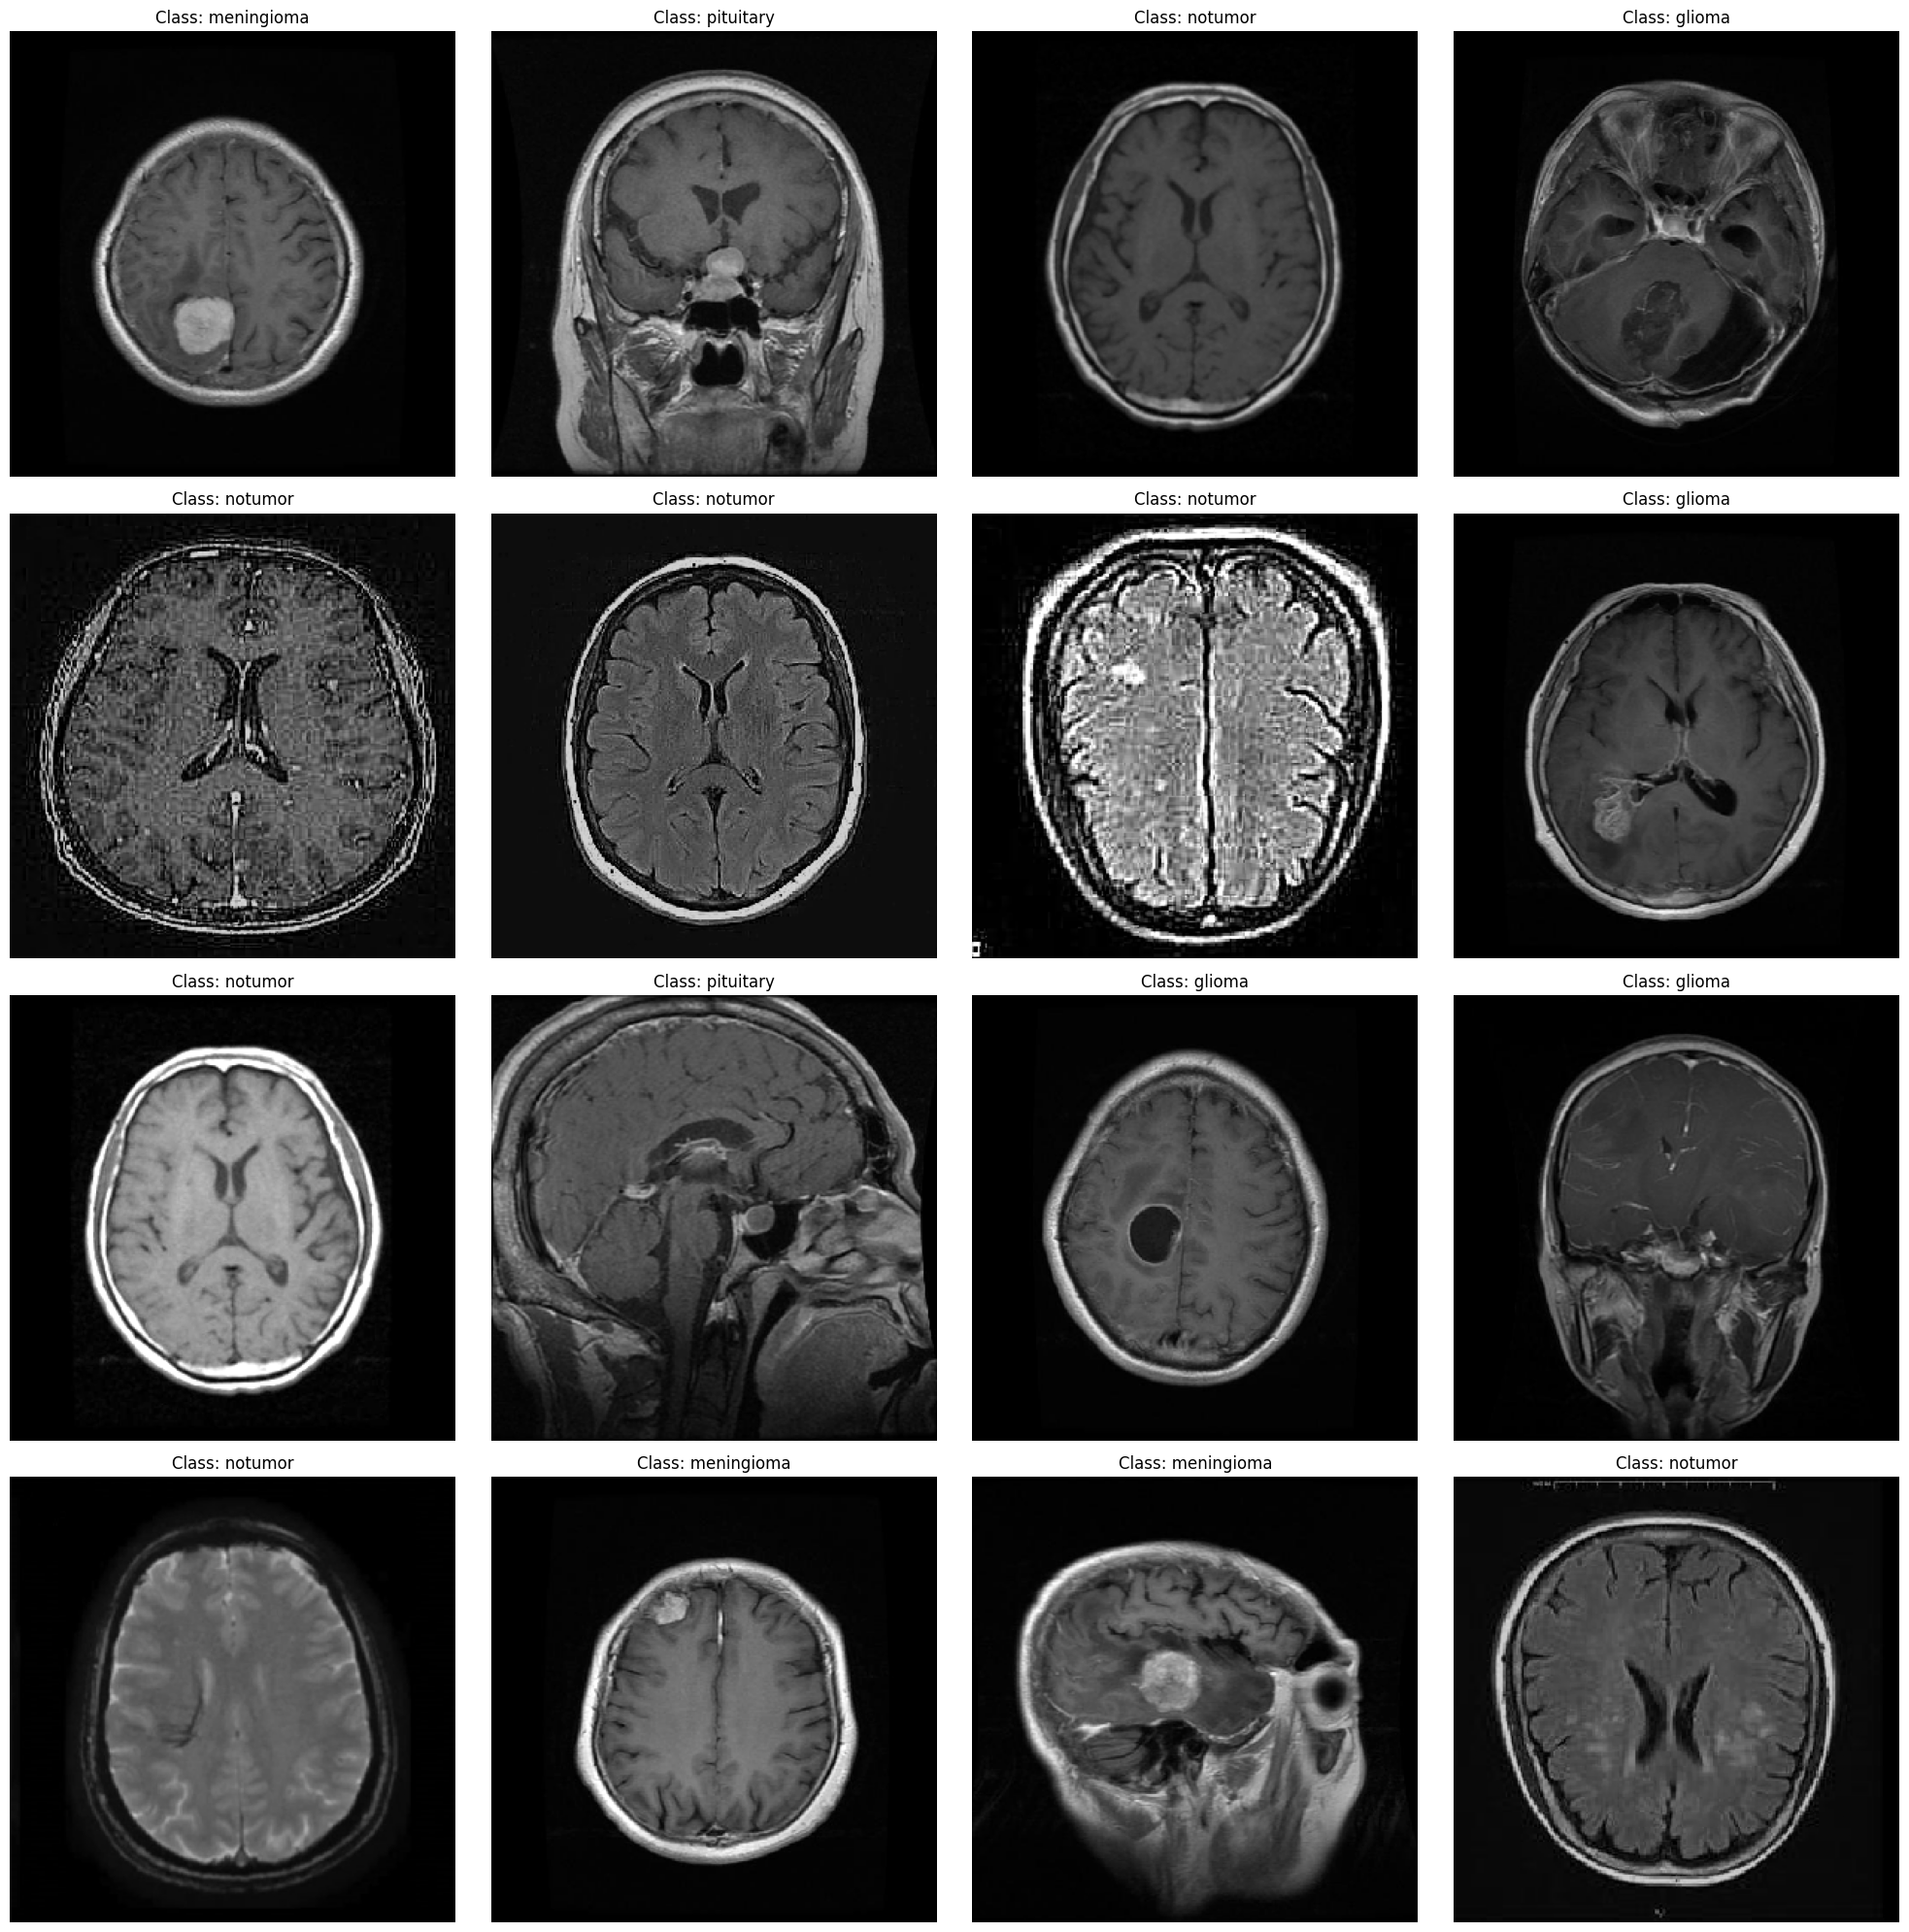

In [12]:
# Create 4 x 4 Grid of Subplots to explain image in tr_gen
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

# Add layers to base model
model = Sequential([
    base_model,
    Flatten(),
    # Dropout layers to prevent overfitting
    Dropout(rate=0.3),
    # Type of function used for Deep learning for non linear relationships
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    # Softmax used for classificaiton often used in last layer
    Dense(4, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Adamax assist with learning steps that model makes in training
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [15]:
# Train Model to Classify MRI Scans
hist = model.fit(
    tr_gen,
    # Model will go through tr set 5 times and update weights accordingly
    epochs=5,
    validation_data=valid_gen
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.5725 - loss: 1.0128 - precision: 0.7760 - recall: 0.4133 - val_accuracy: 0.7573 - val_loss: 0.5972 - val_precision: 0.8013 - val_recall: 0.7267
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 771ms/step - accuracy: 0.9735 - loss: 0.0900 - precision: 0.9749 - recall: 0.9712 - val_accuracy: 0.9099 - val_loss: 0.2044 - val_precision: 0.9193 - val_recall: 0.9038
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 773ms/step - accuracy: 0.9905 - loss: 0.0299 - precision: 0.9906 - recall: 0.9894 - val_accuracy: 0.9710 - val_loss: 0.0780 - val_precision: 0.9738 - val_recall: 0.9664
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 777ms/step - accuracy: 0.9930 - loss: 0.0198 - precision: 0.9931 - recall: 0.9927 - val_accuracy: 0.9634 - val_loss: 0.0895 - val_precision: 0.9634 - val_recall: 0.9634
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 776ms/step - accuracy: 0.9953 - loss: 0.0129 - precision: 0.9955 - recall: 0.9953 - val_accuracy: 0.9786 - val_loss: 

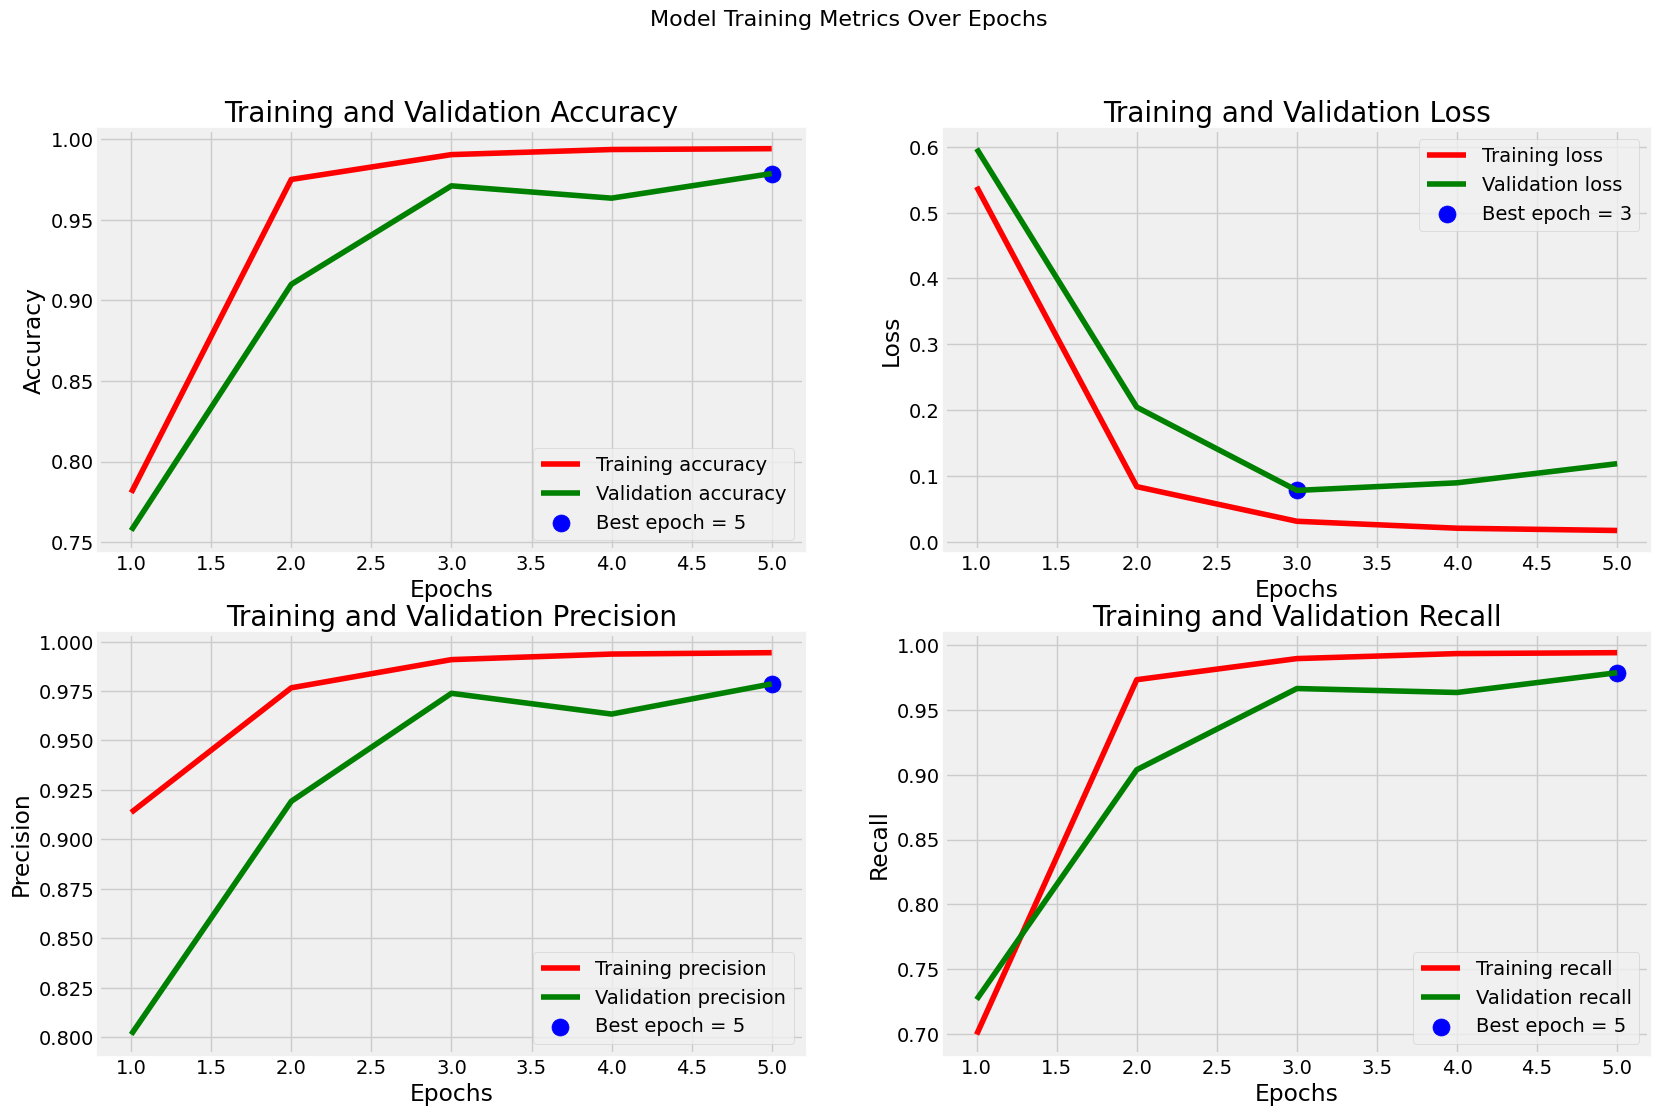

In [16]:
# Getting training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
              label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [17]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f'Traning Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.9962 - loss: 0.0186 - precision: 0.9963 - recall: 0.9962
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.9797 - loss: 0.1326 - precision: 0.9797 - recall: 0.9797
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 1.0000 - loss: 0.0403 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9856 - loss: 0.1115 - precision: 0.9856 - recall: 0.9856
Traning Accuracy: 99.54%
Train Loss: 0.0166


Validation Accuracy: 97.86%
Validation Loss: 0.1261


Test Accuracy: 98.17%
Test Loss: 0.0926


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step


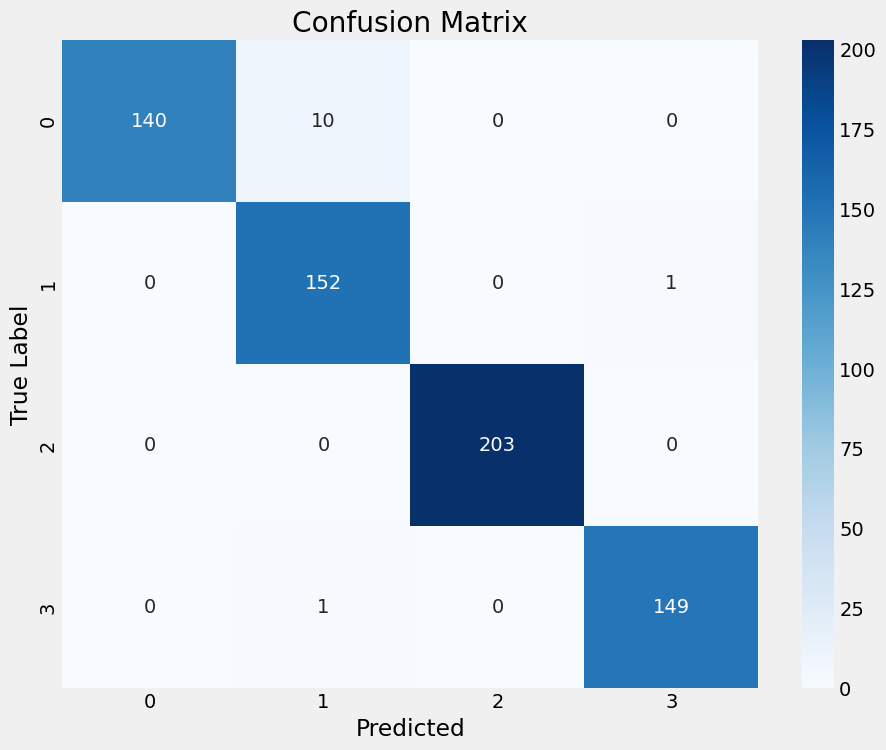

In [18]:
# Confusion Matrix to see where models succeeds and fails
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from PIL import Image

def predict(img_path: str) -> None:
  # Get class labels
  labels = list(class_dict.keys())

  # Create figure
  plt.figure(figsize=(6, 8))

  # Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299, 299))
  img_array = np.array(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f'Input MRI Image\nPredicted: {predicted_class}')

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel('Probability', fontsize=15)
  plt.title('Class Probabilities')

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f'\n\nPredicted tumor type: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


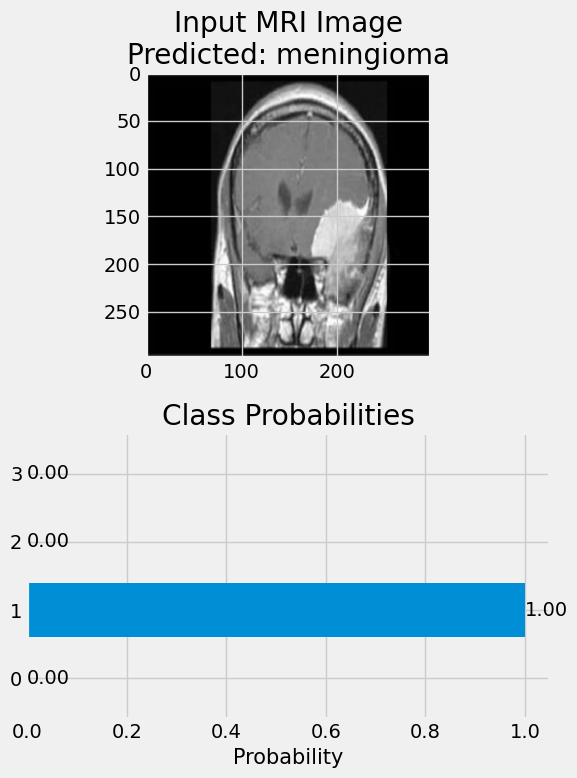



Predicted tumor type: meningioma


In [20]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


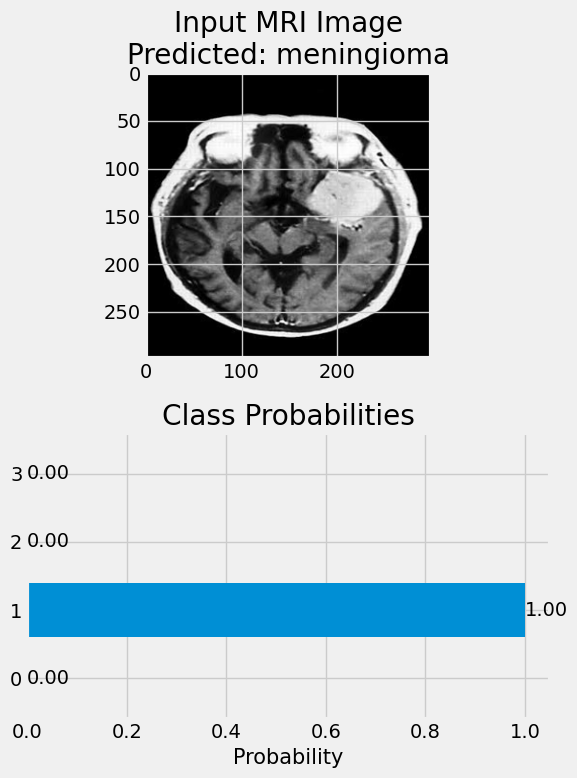



Predicted tumor type: meningioma


In [21]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


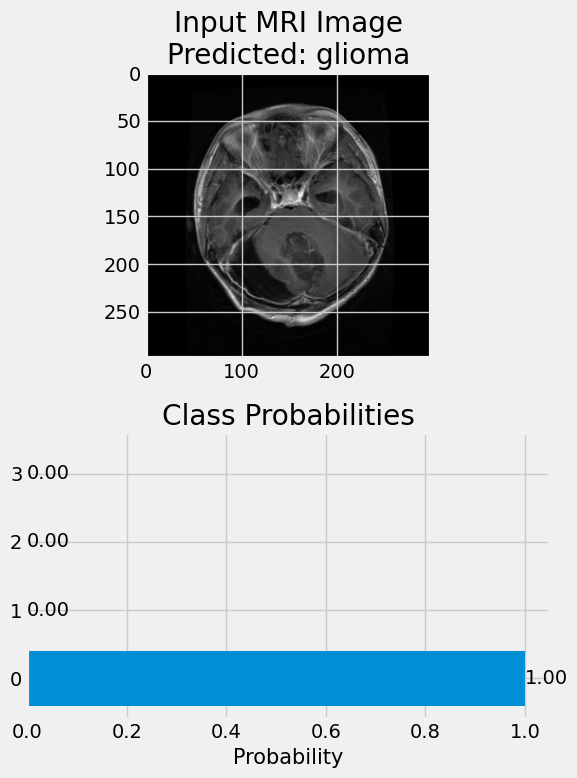



Predicted tumor type: glioma


In [22]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [23]:
model.save_weights('xception_model.weights.h5')